In [1]:
import os
import re
import math
import glob
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [41]:
# import osu.downloader as downloader
# 
# download only S ranks from top 50 on each map
# mapsets = [
#     '1263383 Niji no Conquistador - Zutto Summer de Koishiteru [no video]',
#     '977552 umu - humanly [no video]',
#     '848400 Haywyre - Insight',
#     '675779 Camellia - NUCLEAR-STAR',
#     '936698 sana - Packet Hero',
#     '889855 GALNERYUS - RAISE MY SWORD',
#     '651507 a_hisa - Logical Stimulus',
#     '914242 Kano - Walk This Way!',
#     '463548 Nightcore - Flower Dance',
#     '685822 That Poppy - Altar',
#     '890438 Ata - Euphoria',
#     '431135 Imagine Dragons - Warriors',
#     '1125370 Sheena Ringo - Marunouchi Sadistic (neetskills remix)',
#     '327557 nameless - Milk Crown on Sonnetica',
#     '478405 Omoi - Snow Drive(0123) [no video]'
# ]
# mapsets = downloader.get_all_mapset_folders_on_disk()
# def filter_beatmap(beatmap: bm.Beatmap) -> bool:
#     if beatmap.ar_raw() <= 9:
#         return False
#     
#     return True
# 
# obj_dataset = downloader.download_mapsets(mapsets, filter=filter_beatmap, max=25, only='S')

obj_dataset = dataset.replay_mapping_from_cache(4000)

HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, HT are not supported yet.
HR, DT, EZ, 

In [ ]:
obj_dataset

In [43]:
input = dataset.input_data(obj_dataset, verbose=True)
output = dataset.target_data(obj_dataset, verbose=True)

1578it [07:20,  3.59it/s]
1578it [00:29, 53.26it/s]


In [40]:
input.shape

(81012736, 5)

In [45]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(6692, 2048, 5)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

EPOCHS = 100
BATCH_SIZE = 64

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [47]:

# punish for not smooth movements
class VelocityAwareLoss(nn.Module):
    def __init__(self, position_weight=1.0, velocity_weight=0.3):
        super().__init__()
        self.pos_weight = position_weight
        self.vel_weight = velocity_weight
        
    def forward(self, pred, target):
        # Position loss
        pos_loss = F.mse_loss(pred, target)
        
        # Velocity loss (differences between consecutive timesteps)
        pred_vel = pred[:, 1:] - pred[:, :-1]
        target_vel = target[:, 1:] - target[:, :-1]
        vel_loss = F.mse_loss(pred_vel, target_vel)
        
        return self.pos_weight * pos_loss + self.vel_weight * vel_loss

class OsuModel(nn.Module):
    def __init__(self, input_size, output_size, noise_std=0.2):
        super(OsuModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.dense1 = nn.Linear(64, 64)
        self.noise_std = noise_std
        self.dense2 = nn.Linear(64, 16)
        self.position = nn.Linear(16, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        pos = self.dense1(lstm_out)
        
        # gaussian noise (only applied during training)
        if self.training:
            noise = torch.randn_like(pos) * self.noise_std
            pos = pos + noise
        
        pos = self.dense2(pos)
        pos = self.position(pos)
        
        return pos

input_size = xs.shape[2]  # feature dimension
output_size = ys.shape[2]  # output dimension

model = OsuModel(input_size, output_size)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = VelocityAwareLoss(position_weight=1.0, velocity_weight=0.3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(".trained/most_recent.pt"))
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

OsuModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=16, bias=True)
  (position): Linear(in_features=16, out_features=2, bias=True)
)
Total parameters: 23410


In [48]:
epoch_losses = []

In [ ]:
import tqdm

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_x, batch_y in tqdm.tqdm(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        # print(batch_x.shape)
        # print(batch_y.shape)
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}')
    epoch_losses.append(epoch_loss)
    

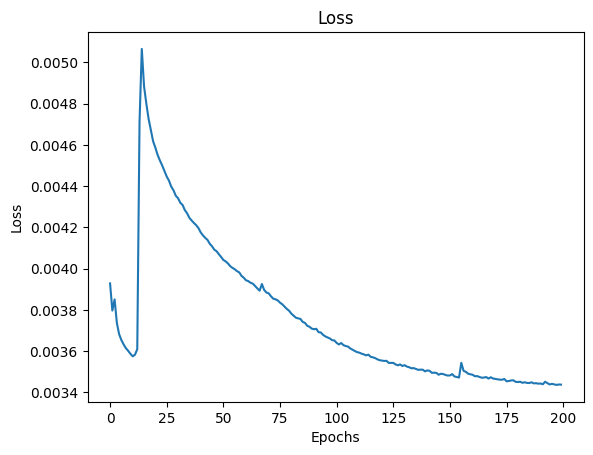

In [56]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

if not os.path.exists('.trained'):
    os.makedirs('.trained')

import datetime
now = datetime.datetime.now()
torch.save(model.state_dict(), f'.trained/{now.strftime("%Y-%m-%d_%H-%M-%S")}.pt')
torch.save(model.state_dict(), f'.trained/most_recent.pt')

In [68]:
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'rubiks'

test_map = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data).to(device)

In [69]:
with torch.no_grad():
    replay_data = model(data).to('cpu').numpy()
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

In [70]:
import osu.preview.preview as preview

preview.preview_replay(replay_data, test_map, test_song)